## Training Simple ResNet on Leaf Dataset

### Installs (optional)

In [1]:
# %pip install torch torchvision scikit-learn ultralytics opencv-python matplotlib

### Imports, paths, load metadata, add image paths

In [2]:
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFile, UnidentifiedImageError
import numpy as np

ROOT = Path("./invasive_plants_hawaii")
METADATA_DIR = ROOT / "metadata"
IMAGES_DIR = ROOT / "images"

print("ROOT:", ROOT.resolve())
print("Images dir exists?", IMAGES_DIR.exists())
print("Metadata dir exists?", METADATA_DIR.exists())

dorsal_csv = METADATA_DIR / "full_dataset_dorsal.csv"
ventral_csv = METADATA_DIR / "full_dataset_ventral.csv"
both_csv   = METADATA_DIR / "full_dataset.csv"

df_dorsal  = pd.read_csv(dorsal_csv)
df_ventral = pd.read_csv(ventral_csv)
df_both    = pd.read_csv(both_csv)

def add_image_path(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(
        image_path=lambda d: d.apply(
            lambda row: IMAGES_DIR / row["session"] / row["filename"],
            axis=1,
        )
    )

df_dorsal  = add_image_path(df_dorsal)
df_ventral = add_image_path(df_ventral)
df_both    = add_image_path(df_both)

df_dorsal[["session", "filename", "image_path"]].head()

ROOT: C:\Users\bigbo\Downloads\ai_for_conservation\invasive_plants_hawaii
Images dir exists? True
Metadata dir exists? True


,session,filename,image_path
0,session_1_1_16_2025,DSC00752.png,invasive_plants_hawaii\images\session_1_1_16_2...
1,session_1_1_16_2025,DSC00675.png,invasive_plants_hawaii\images\session_1_1_16_2...
2,session_1_1_16_2025,DSC00687.png,invasive_plants_hawaii\images\session_1_1_16_2...
3,session_1_1_16_2025,DSC00734.png,invasive_plants_hawaii\images\session_1_1_16_2...
4,session_1_1_16_2025,DSC00732.png,invasive_plants_hawaii\images\session_1_1_16_2...


### Sanity-check one image

Using path: invasive_plants_hawaii\images\session_1_1_16_2025\DSC00752.png
Exists? True
Original size: (6000, 4000) -> Display size: (512, 341)


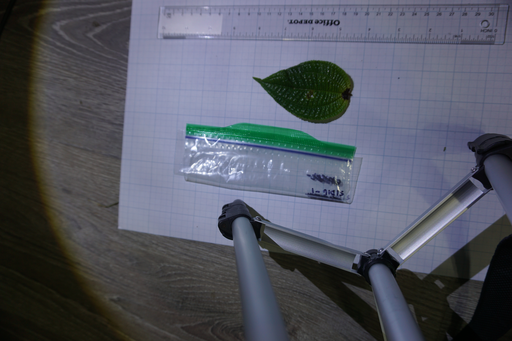

In [ ]:
from IPython.display import display
from PIL import Image, UnidentifiedImageError

ImageFile.LOAD_TRUNCATED_IMAGES = True

path = df_dorsal["image_path"].iloc[0]
print("Using path:", path)
print("Exists?", path.exists())

try:
    img = Image.open(path)
    img.load()

    max_side = 512 
    w, h = img.size
    scale = max_side / max(w, h)
    new_size = (int(w * scale), int(h * scale))

    img_small = img.resize(new_size, Image.LANCZOS)
    print("Original size:", (w, h), "-> Display size:", new_size)

    display(img_small)

except UnidentifiedImageError as e:
    print("Not a valid image (maybe Git LFS pointer):", e)
except Exception as e:
    print("Other error:", e)


### Preprocessing: drop expert labels + encode Yes/Maybe/No → binary

In [4]:
# Base label columns from the metadata
BASE_LABEL_COLS = ["healthy", "rust", "leaf_miner", "other_insect", "mechanical_damage"]

# 1) Drop all expert_* columns
def drop_expert_columns(df: pd.DataFrame) -> pd.DataFrame:
    expert_cols = [c for c in df.columns if c.startswith("expert_")]
    return df.drop(columns=expert_cols)

# 2) Map Yes/Maybe/No -> binary, with Maybe -> No
def encode_yes_maybe_no(value):
    if isinstance(value, str):
        v = value.strip().lower()
        if v == "yes":
            return 1
        # everything else (no, maybe, blank, NaN) -> 0
    return 0

def add_binary_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in BASE_LABEL_COLS:
        new_col = f"{col}_label"
        df[new_col] = df[col].apply(encode_yes_maybe_no).astype("int64")
    return df

# Multi-label columns
LABEL_COLS = [
    "healthy_label",
    "rust_label",
    "leaf_miner_label",
    "other_insect_label",
    "mechanical_damage_label",
]

# Apply preprocessing to dorsal/ventral/both
df_dorsal_clean  = add_binary_labels(drop_expert_columns(df_dorsal))
df_ventral_clean = add_binary_labels(drop_expert_columns(df_ventral))
df_both_clean    = add_binary_labels(drop_expert_columns(df_both))

df_dorsal_clean[LABEL_COLS].mean()  # prevalence per label

healthy_label              0.191230
rust_label                 0.453106
leaf_miner_label           0.207065
other_insect_label         0.222899
mechanical_damage_label    0.185140
dtype: float64

### Train / val / test split (70 / 15 / 15)

In [ ]:
from sklearn.model_selection import train_test_split

# Use both dorsal + ventral
df = df_both_clean.copy()

# Define "any_damage" = at least one non-healthy damage present
damage_cols = ["rust_label", "leaf_miner_label", "other_insect_label", "mechanical_damage_label"]
df["any_damage"] = (df[damage_cols].sum(axis=1) > 0).astype(int)

print("any_damage prevalence (overall):", df["any_damage"].mean())

# First: train (70%) vs temp (30%), stratified by any_damage
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df["any_damage"],
)

# Then: split temp into val and test (each 15% total), stratified by any_damage
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50, # half of 30% -> 15% of total
    random_state=42,
    stratify=temp_df["any_damage"],
)

print("Sizes:")
print("  train:", len(train_df))
print("  val:  ", len(val_df))
print("  test: ", len(test_df))

print("\nany_damage prevalence:")
print("  train:", train_df["any_damage"].mean())
print("  val:  ", val_df["any_damage"].mean())
print("  test: ", test_df["any_damage"].mean())

any_damage prevalence (overall): 0.7618757612667478
Sizes:
  train: 1149
  val:   246
  test:  247

any_damage prevalence:
  train: 0.7615317667536988
  val:   0.7642276422764228
  test:  0.7611336032388664


### Dataset + transforms + DataLoaders (train/val/test)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import numpy as np

# Image transforms (ImageNet-ish)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

class InvasivePlantsDataset(Dataset):
    def __init__(self, df, label_cols, transform=None):
        self.df = df.reset_index(drop=True)
        self.label_cols = label_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = Path(row["image_path"])
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
        return img, labels

train_dataset = InvasivePlantsDataset(train_df, LABEL_COLS, transform=train_transform)
val_dataset   = InvasivePlantsDataset(val_df,   LABEL_COLS, transform=eval_transform)
test_dataset  = InvasivePlantsDataset(test_df,  LABEL_COLS, transform=eval_transform)

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0, # CPU + Windows
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

print("DataLoaders ready.")

DataLoaders ready.


### ResNet-18 (frozen) + training + metrics (val & test)

In [7]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve

device = torch.device("cpu")
print("Using device:", device)

# Small, fast ResNet
base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = base_model.fc.in_features

# Freeze backbone
for param in base_model.parameters():
    param.requires_grad = False

# New classifier head: one logit per damage type
base_model.fc = nn.Linear(num_features, len(LABEL_COLS))
model = base_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


@torch.no_grad()
def evaluate_acc(model, loader, criterion, device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in tqdm(loader, desc="Eval", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)
        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).float()

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    acc = (all_preds == all_labels).float().mean().item()
    avg_loss = running_loss / len(loader.dataset)

    return avg_loss, acc


@torch.no_grad()
def collect_predictions(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    return all_probs, all_labels


def tune_thresholds_per_label(probs, labels, label_names):
    thresholds = {}
    per_label_results = []

    for j, name in enumerate(label_names):
        y_true = labels[:, j]
        y_score = probs[:, j]

        if len(np.unique(y_true)) < 2:
            thresholds[name] = 0.5
            per_label_results.append((name, np.nan, np.nan, 0.5))
            continue

        precision, recall, thr = precision_recall_curve(y_true, y_score)
        f1s = 2 * precision * recall / (precision + recall + 1e-8)

        if len(thr) == 0:
            thresholds[name] = 0.5
            per_label_results.append((name, np.nan, np.nan, 0.5))
            continue

        best_idx = int(np.nanargmax(f1s))
        if best_idx >= len(thr):
            best_idx = len(thr) - 1

        best_thr = thr[best_idx]
        y_pred_best = (y_score >= best_thr).astype(int)
        best_f1 = f1_score(y_true, y_pred_best, zero_division=0)
        auc = roc_auc_score(y_true, y_score)

        thresholds[name] = best_thr
        per_label_results.append((name, best_f1, auc, best_thr))

    return thresholds, per_label_results


def compute_metrics_with_thresholds(probs, labels, label_names, thresholds):
    per_label = []
    for j, name in enumerate(label_names):
        y_true = labels[:, j]
        y_score = probs[:, j]
        thr = thresholds.get(name, 0.5)
        y_pred = (y_score >= thr).astype(int)

        if len(np.unique(y_true)) < 2:
            f1 = np.nan
            auc = np.nan
        else:
            f1 = f1_score(y_true, y_pred, zero_division=0)
            auc = roc_auc_score(y_true, y_score)

        per_label.append((name, f1, auc, thr))
    return per_label


Using device: cpu


### Training loop

In [8]:
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_acc(model, val_loader, criterion, device, threshold=0.5)

    print(
        f"Epoch {epoch:02d}: "
        f"train_loss={train_loss:.4f}  "
        f"val_loss={val_loss:.4f}  "
        f"val_acc@0.5={val_acc:.4f}"
    )

Epoch 01: train_loss=0.5375  val_loss=0.5053  val_acc@0.5=0.7520


Epoch 02: train_loss=0.4972  val_loss=0.4854  val_acc@0.5=0.7593


Epoch 03: train_loss=0.4809  val_loss=0.4713  val_acc@0.5=0.7561


Epoch 04: train_loss=0.4632  val_loss=0.4719  val_acc@0.5=0.7577


Epoch 05: train_loss=0.4572  val_loss=0.4578  val_acc@0.5=0.7650


### Metrics (val + test) with tuned thresholds

In [9]:
probs_val, labels_val   = collect_predictions(model, val_loader, device)
probs_test, labels_test = collect_predictions(model, test_loader, device)

val_thresholds, val_results = tune_thresholds_per_label(
    probs_val, labels_val, LABEL_COLS
)

print("\nPer-label (VAL) F1/ROC-AUC with tuned thresholds:")
for name, f1, auc, thr in val_results:
    print(f"{name}: F1={f1:.3f}, ROC-AUC={auc:.3f}, thr={thr:.3f}")

test_results = compute_metrics_with_thresholds(
    probs_test, labels_test, LABEL_COLS, val_thresholds
)

print("\nPer-label (TEST) F1/ROC-AUC using VAL-tuned thresholds:")
for name, f1, auc, thr in test_results:
    print(f"{name}: F1={f1:.3f}, ROC-AUC={auc:.3f}, thr={thr:.3f}")


Per-label (VAL) F1/ROC-AUC with tuned thresholds:
healthy_label: F1=0.473, ROC-AUC=0.758, thr=0.252
rust_label: F1=0.647, ROC-AUC=0.646, thr=0.422
leaf_miner_label: F1=0.632, ROC-AUC=0.860, thr=0.264
other_insect_label: F1=0.552, ROC-AUC=0.789, thr=0.336
mechanical_damage_label: F1=0.529, ROC-AUC=0.776, thr=0.203

Per-label (TEST) F1/ROC-AUC using VAL-tuned thresholds:
healthy_label: F1=0.455, ROC-AUC=0.745, thr=0.252
rust_label: F1=0.640, ROC-AUC=0.678, thr=0.422
leaf_miner_label: F1=0.608, ROC-AUC=0.846, thr=0.264
other_insect_label: F1=0.576, ROC-AUC=0.810, thr=0.336
mechanical_damage_label: F1=0.405, ROC-AUC=0.719, thr=0.203


## YOLO model for leaf detection & "most-green" leaf crop

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load YOLO leaf model
yolo_model_path = "yolo11x_leaf.pt" # adjust path if needed
yolo_model = YOLO(yolo_model_path)

In [11]:
def green_fraction(pil_img):
    """
    Compute fraction of 'green' pixels in a PIL.Image (RGB).
    Uses HSV with a typical green range.
    """
    arr = np.array(pil_img)
    if arr.size == 0:
        return 0.0

    hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV)

    # Approx green in HSV
    lower_green = np.array([35, 40, 40], dtype=np.uint8)
    upper_green = np.array([85, 255, 255], dtype=np.uint8)

    mask = cv2.inRange(hsv, lower_green, upper_green)
    green_pixels = np.count_nonzero(mask)
    total_pixels = arr.shape[0] * arr.shape[1]

    if total_pixels == 0:
        return 0.0

    return green_pixels / total_pixels

In [12]:
def get_most_green_leaf_crop(
    image_path,
    model,
    conf_threshold=0.15,
    pad_ratio=0.1,
    min_green_fraction=0.0,
    show_candidates=False,
):
    """
    Run YOLO on image_path, keep boxes with conf >= conf_threshold.
    For each box:
      - compute green_fraction INSIDE the original bbox
      - also build a padded bbox for cropping

    Pick the box with the highest green_fraction (optionally requiring
    min_green_fraction), and return the padded crop.
    """
    image_path = Path(image_path)
    image = Image.open(image_path).convert("RGB")
    w, h = image.size

    results = model.predict(
        source=str(image_path),
        task="detect",
        save=False,
        conf=conf_threshold,
        verbose=False,
    )

    if len(results) == 0:
        return None, None

    result = results[0]
    boxes = result.boxes

    if boxes is None or len(boxes) == 0:
        return None, None

    xyxy = boxes.xyxy.cpu().numpy()
    scores = boxes.conf.cpu().numpy()

    candidates = []

    for (x1, y1, x2, y2), score in zip(xyxy, scores):
        # Original bbox for green fraction
        x1_o, y1_o, x2_o, y2_o = map(int, [x1, y1, x2, y2])
        x1_o = max(0, x1_o)
        y1_o = max(0, y1_o)
        x2_o = min(w, x2_o)
        y2_o = min(h, y2_o)

        if x2_o <= x1_o or y2_o <= y1_o:
            continue

        crop_orig = image.crop((x1_o, y1_o, x2_o, y2_o))
        g_frac = green_fraction(crop_orig)

        # Padded bbox for output crop
        bw = x2 - x1
        bh = y2 - y1
        pad_x = pad_ratio * bw
        pad_y = pad_ratio * bh

        x1_pad = max(0, int(x1 - pad_x))
        y1_pad = max(0, int(y1 - pad_y))
        x2_pad = min(w, int(x2 + pad_x))
        y2_pad = min(h, int(y2 + pad_y))

        crop_padded = image.crop((x1_pad, y1_pad, x2_pad, y2_pad))

        candidates.append({
            "crop_orig": crop_orig,
            "crop_padded": crop_padded,
            "green_fraction": g_frac,
            "score": float(score),
            "bbox_orig": (x1_o, y1_o, x2_o, y2_o),
            "bbox_padded": (x1_pad, y1_pad, x2_pad, y2_pad),
        })

    if min_green_fraction > 0.0:
        candidates = [c for c in candidates if c["green_fraction"] >= min_green_fraction]

    if not candidates:
        return None, None

    best = max(candidates, key=lambda c: c["green_fraction"])
    best_crop = best["crop_padded"]

    if show_candidates:
        candidates_sorted = sorted(candidates, key=lambda c: c["green_fraction"], reverse=True)
        n = len(candidates_sorted)
        cols = min(3, n)
        rows = int(np.ceil(n / cols))

        plt.figure(figsize=(4 * cols, 4 * rows))
        for i, c in enumerate(candidates_sorted):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(c["crop_padded"])
            plt.axis("off")
            plt.title(f"green={c['green_fraction']:.2f} conf={c['score']:.2f}")
        plt.suptitle(f"Leaf crops (sorted by green fraction) - {image_path.name}")
        plt.show()

    return best_crop, best

Image: invasive_plants_hawaii\images\session_3_1_19_2025\IMG_0629.png


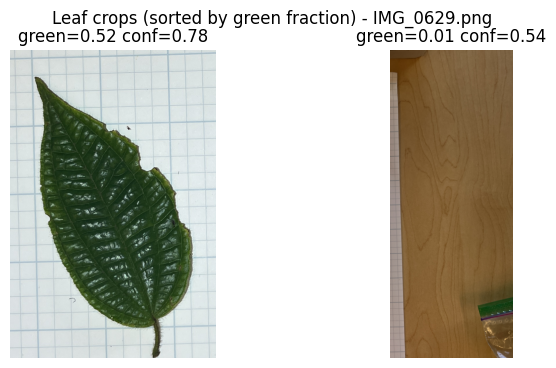

Chosen bbox green_fraction: 0.5182409735685356
Chosen bbox (padded): (1203, 1068, 1911, 2128)


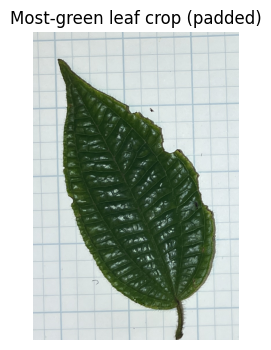

In [20]:
# Example: get most-green crop from a random dorsal image
row = df_dorsal_clean.sample(1).iloc[0]
print("Image:", row["image_path"])

best_crop, info = get_most_green_leaf_crop(
    image_path=row["image_path"],
    model=yolo_model,
    conf_threshold=0.15,
    pad_ratio=0.1,
    show_candidates=True,
)

if best_crop is not None:
    print("Chosen bbox green_fraction:", info["green_fraction"])
    print("Chosen bbox (padded):", info["bbox_padded"])
    plt.figure(figsize=(4, 4))
    plt.imshow(best_crop)
    plt.axis("off")
    plt.title("Most-green leaf crop (padded)")
    plt.show()
else:
    print("No bbox met the green fraction requirement.")